In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, Embedding, Add, TimeDistributed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout2D, RepeatVector
from keras.callbacks import EarlyStopping
from keras import metrics
from sklearn.model_selection import KFold
import gzip
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from geopy.distance import great_circle

## training and testing data

In [2]:
# data loading
with gzip.open('../data/segment_with_noise/ll_seg_500_noise.pkl.gzip', 'rb') as f:
    ll_seg_gps_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise/rl_seg_500_noise.pkl.gzip', 'rb') as f:
    rl_seg_gps_noise = pickle.load(f)

with gzip.open('../data/segment_groud_truth/rl_seg_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_gps_noise))
print(ll_seg_gps_noise[0].shape[0])
ll_seg_gps_noise[0].head()

500
77


,y,x,y_norm,x_norm,Vy_norm,Vx_norm,theta_norm,psi_norm,phi_norm,omega_Xv_norm,omega_Yv_norm,alpha_Xv_norm,alpha_Yv_norm,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.786530,0.206384,0.764706,0.778120,0.659098,0.423909,0.453957,0.466896,0.411583,0.508045,0.593818,0.795350,0.203490
43617,42.246167,-83.563112,0.785304,0.204631,0.764706,0.771957,0.658926,0.425454,0.448492,0.418745,0.388417,0.478467,0.536334,0.787305,0.203073
43667,42.246155,-83.563137,0.784089,0.202890,0.764706,0.764253,0.658731,0.431827,0.465695,0.474635,0.473359,0.473024,0.564262,0.788982,0.203170
43717,42.246143,-83.563163,0.782877,0.201164,0.764706,0.758089,0.658551,0.429316,0.485732,0.501290,0.439382,0.472314,0.590835,0.794082,0.195338
43767,42.246131,-83.563188,0.781676,0.199454,0.705882,0.753467,0.658312,0.419467,0.495041,0.423044,0.462548,0.519404,0.539588,0.791014,0.203958


In [23]:
x_ll = [] # sampled noisy GPS, list of lists of tuples, (500, 77, 5, 2)
y_gps_ll = [] # sampled noisy GPS, list of lists of tuples, (500, 77, 2)
y_ll = [] # unsampled groud truth GPS, list of lists of tuples, (500, 3822, 2)

x_rl = [] # sampled noisy GPS, list of lists of tuples, (100, 77, 5, 2)
y_gps_rl = [] # sampled noisy GPS, list of lists of tuples, (100, 77, 5, 2)

# LEFT LANE
for df in ll_seg_gps_noise:
    # x_ll.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'alpha_Xv', 'Vy_norm']].values)
    x_ll.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'alpha_Xv_norm', 'alpha_Yv_norm']].values)
    y_gps_ll.append(df[['y_norm', 'x_norm']].values)

for df in ll_seg_gps_gt:
    y_ll.append(df[['y_norm', 'x_norm']].values)

# RIGHT LANE
np.random.seed(1)
# for df in random.sample(rl_seg_gps_noise, 500):
for df in rl_seg_gps_noise:
    # x_rl.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'Vx_norm', 'Vy_norm']].values)
    x_rl.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'alpha_Xv_norm', 'alpha_Yv_norm']].values)
    y_gps_rl.append(df[['y_norm', 'x_norm']].values)

In [24]:
# model parameters

max_x_len = max([len(x_seg) for x_seg in x_ll])
x_features_dim = x_ll[0].shape[1]
y_features_dim = y_ll[0].shape[1]
embedding_dim = 128
latent_dim = 300

max_x_len, x_features_dim, y_features_dim

(77, 5, 2)

In [25]:
# redefine training inputs to use built-in train-test-split in model.fit()
x_train = np.asarray(x_ll) # (500, 77, 5, 2)
x_temp = np.asarray([np.arange(max_x_len) for i in np.arange(len(x_ll))])
y_train = np.asarray(y_gps_ll) # (500, 77, 2)

# use right lane segments as testing set
x_test = np.asarray(x_rl) # (100, 77, 5, 2)
y_test = np.asarray(y_gps_rl) # (100, 77, 2)

x_test.shape, y_test.shape

((500, 77, 5), (500, 77, 2))

## model design: LSTM autoencoder

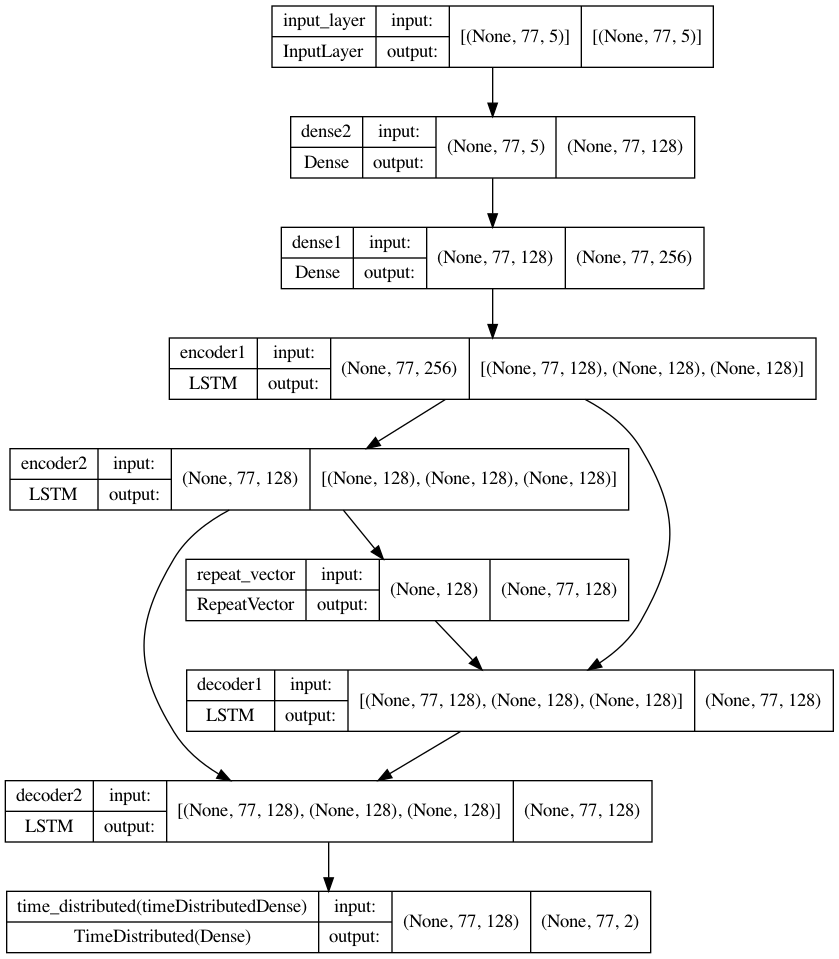

In [6]:
x_input = Input(shape=(max_x_len,x_features_dim,), name='input_layer')

# dense layer of spatial embedding
x_embedd1 = Dense(256, name='dense1')
x_embedd2 = Dense(embedding_dim, name='dense2')
x_h_st = x_embedd1(x_embedd2(x_input))

# encoder
encoder_l1 = LSTM(
    embedding_dim, return_sequences = True, return_state=True, 
    recurrent_dropout=0.1, name='encoder1'
    )
encoder_outputs1 = encoder_l1(x_h_st)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = LSTM(
    embedding_dim, return_state=True, name='encoder2'
    )
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

# decoder
decoder_inputs = RepeatVector(max_x_len)(encoder_outputs2[0])
decoder_l1 = LSTM(
    embedding_dim, return_sequences=True, name='decoder1'
    )(decoder_inputs, initial_state = encoder_states1)
decoder_l2 = LSTM(
    embedding_dim, return_sequences=True, name='decoder2'
    )(decoder_l1, initial_state = encoder_states2)
decoder_outputs2 = TimeDistributed(Dense(y_features_dim, name='timeDistributedDense'))(decoder_l2)

model_e2d2 = Model(inputs=x_input, outputs=decoder_outputs2)
model_e2d2.compile(
    loss='mean_squared_error', optimizer='adam', 
    metrics=[metrics.mean_absolute_percentage_error]
    )

# save model achitecture as plot
dot_img_file = '../models/autoencode_v2/model.png'
tf.keras.utils.plot_model(model_e2d2, to_file=dot_img_file, show_shapes=True)

In [139]:
# reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
mc = keras.callbacks.ModelCheckpoint(
    '../models/autoencode_v4/autoencode_v4', monitor='mean_absolute_percentage_error', save_weights_only=True,
    mode='min', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)

history = model_e2d2.fit(
    x_train, y_train,
    validation_split = 0.1,
    epochs = 500, batch_size = 50, callbacks=[mc]
)

Epoch 1/500
9/9 [==============================] - ETA: 0s - loss: 0.1231 - mean_absolute_percentage_error: 30413.8496
Epoch 1: mean_absolute_percentage_error improved from inf to 30413.84961, saving model to ../models/autoencode_v4/autoencode_v4
9/9 [==============================] - 7s 294ms/step - loss: 0.1231 - mean_absolute_percentage_error: 30413.8496 - val_loss: 0.0398 - val_mean_absolute_percentage_error: 11603.4531
Epoch 2/500
9/9 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_percentage_error: 29092.2070
Epoch 2: mean_absolute_percentage_error improved from 30413.84961 to 29092.20703, saving model to ../models/autoencode_v4/autoencode_v4
9/9 [==============================] - 2s 172ms/step - loss: 0.0236 - mean_absolute_percentage_error: 29092.2070 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 2800.8303
Epoch 3/500
9/9 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_percentage_error: 8763.5459
Epoch 3: mean_absol

### loading and saving model

- model/autoencode_v1: baseline model to be improved
    - epoch=100, val_loss~=800
- model/autoencode_v2: model with 5 features, 
    - x, y, theta, Vx, Vy 
    - epoch=500, saved val_loss~=700
- model/autoencode_v3: model with reselected 5 features based on PCA
    - x, y, theta, alpha_x, alpha_y
    - epoch=500, saved val_loss~=315
- model/autoencode_v4: model with reselected 5 features based on PCA
    - x, y, theta, alpha_x, alpha_y
    - epoch=500, saved val_loss~=223

In [7]:
# model_e2d2.save('../models/autoencode_v1')
# model_e2d2 = keras.models.load_model('../models/autoencode_v1')
# model_e2d2.load_weights('../models/autoencode_v2/autoencode_v2')

model_e2d2.load_weights('../models/autoencode_v4/autoencode_v4')

## model evaulation

### loss

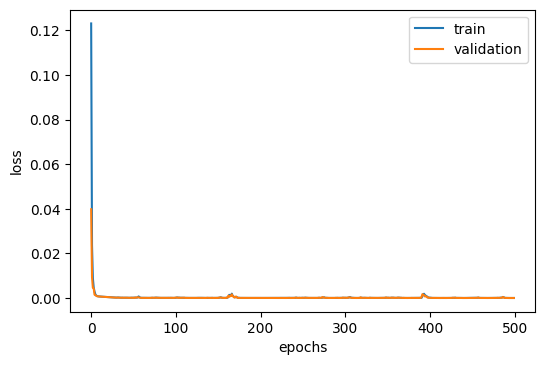

In [143]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

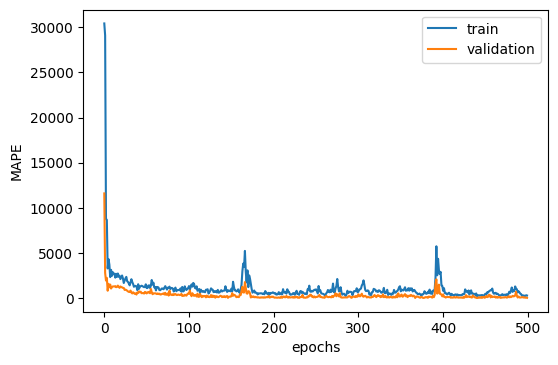

In [144]:
plt.plot(history.history['mean_absolute_percentage_error'], label='train')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='validation')
plt.xlabel('epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [26]:
sample = 2

y_pred = model_e2d2.predict(
    [x_train[sample].reshape(1, max_x_len, 5)], #, np.arange(max_x_len).reshape(1, max_x_len)]
    ).reshape(max_x_len, 2)

y_pred.shape, x_train[sample].shape

((77, 2), (77, 5))

In [27]:
train_mspe = model_e2d2.evaluate(x_train, y_train)
test_mspe = model_e2d2.evaluate(x_test, y_test)

print()
print("Train set [MSE, MAPE] with LSTM autoencoders = ", train_mspe)
print("Test set [MSE, MAPE] with LSTM autoencoders = ", test_mspe)

16/16 [==============================] - 1s 41ms/step - loss: 1.0306e-05 - mean_absolute_percentage_error: 245.6499

Train set [MSE, MAPE] with LSTM autoencoders =  [1.0305877367500216e-05, 245.6499481201172]
Test set [MSE, MAPE] with LSTM autoencoders =  [1.0305877367500216e-05, 245.6499481201172]


In [20]:
train_mspe = model_e2d2.evaluate(x_train, y_train)
test_mspe = model_e2d2.evaluate(x_test, y_test)

print()
print("Train set [MSE, MAPE] with LSTM autoencoders = ", train_mspe)
print("Test set [MSE, MAPE] with LSTM autoencoders = ", test_mspe)

16/16 [==============================] - 1s 43ms/step - loss: 1.0306e-05 - mean_absolute_percentage_error: 245.6500

Train set [MSE, MAPE] with LSTM autoencoders =  [1.0305877367500216e-05, 245.6499481201172]
Test set [MSE, MAPE] with LSTM autoencoders =  [1.0305878276994918e-05, 245.6500244140625]


In [28]:
y_test_pred = model_e2d2.predict(x_test)
y_test_pred.shape

(500, 77, 2)

### visualization

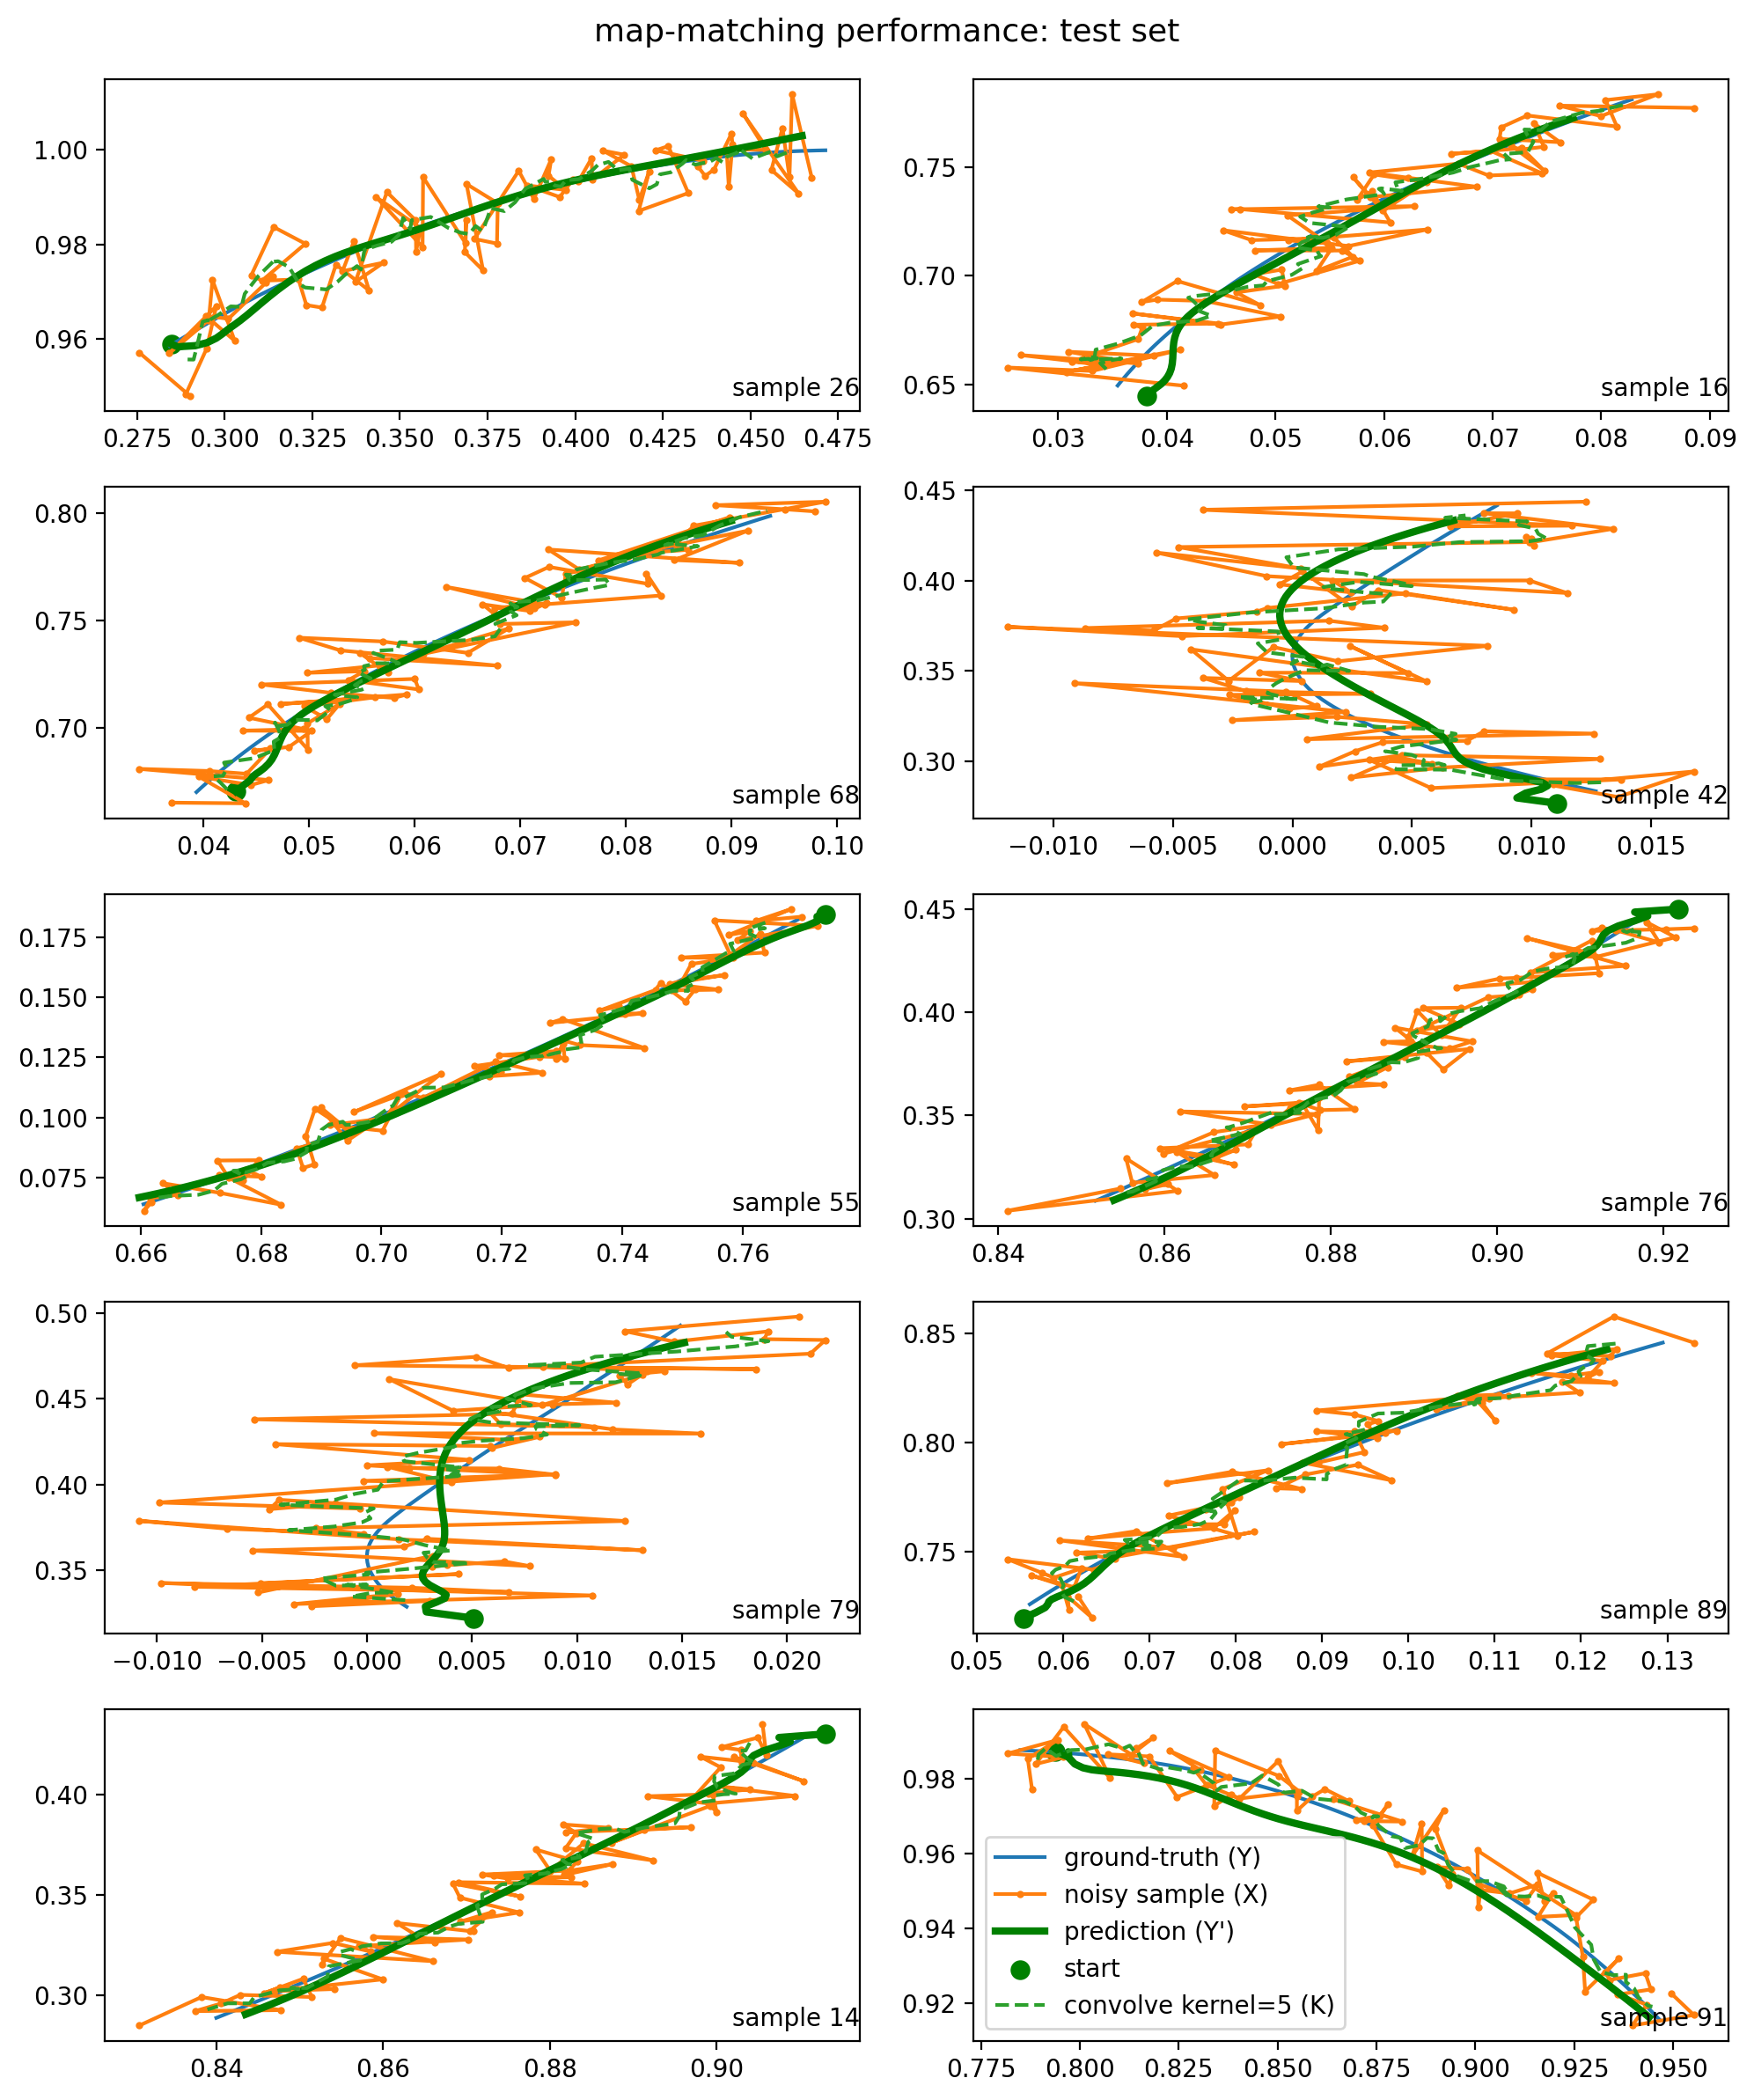

In [30]:
# autoencoder_v4

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 12), dpi=200)
plt.subplots_adjust(hspace=0.5)
fig.suptitle("map-matching performance: test set", fontsize=13, y=0.99)

np.random.seed(200)
for sample, ax in zip(np.random.randint(0, 100, 10), axs.ravel()):
    y_pred = y_test_pred[sample]
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    lat_noisy_convolved = np.convolve(x_test[sample][:, 0], kernel, mode='valid')
    lon_noisy_convolved = np.convolve(x_test[sample][:, 1], kernel, mode='valid')

    ax.plot(y_test[sample][:, 0], y_test[sample][:, 1], label='ground-truth (Y)')
    ax.plot(x_test[sample][:, 0], x_test[sample][:, 1], '-o', label='noisy sample (X)', ms=2)
    ax.plot(y_pred[:, 0], y_pred[:, 1], label="prediction (Y')", linewidth=3, c='green')
    ax.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
    ax.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5 (K)')
    ax.set_title(f'sample {sample}', y=0, loc='right', fontdict={'fontsize': 10})

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

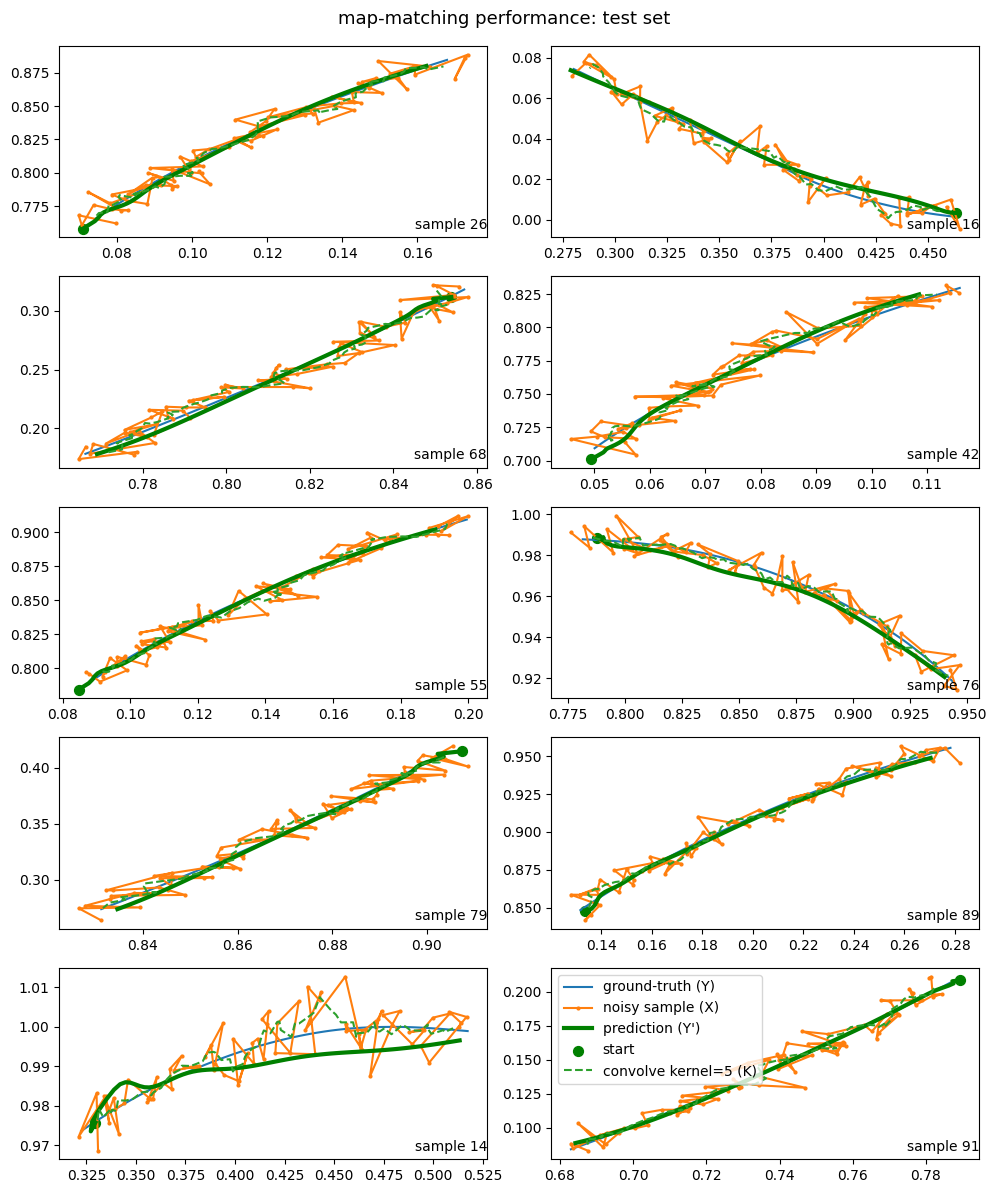

In [204]:
# autoencoder_v4

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("map-matching performance: test set", fontsize=13, y=0.99)

np.random.seed(200)
for sample, ax in zip(np.random.randint(0, 100, 10), axs.ravel()):
    y_pred = y_test_pred[sample]
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    lat_noisy_convolved = np.convolve(x_test[sample][:, 0], kernel, mode='valid')
    lon_noisy_convolved = np.convolve(x_test[sample][:, 1], kernel, mode='valid')

    ax.plot(y_test[sample][:, 0], y_test[sample][:, 1], label='ground-truth (Y)')
    ax.plot(x_test[sample][:, 0], x_test[sample][:, 1], '-o', label='noisy sample (X)', ms=2)
    ax.plot(y_pred[:, 0], y_pred[:, 1], label="prediction (Y')", linewidth=3, c='green')
    ax.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
    ax.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5 (K)')
    ax.set_title(f'sample {sample}', y=0, loc='right', fontdict={'fontsize': 10})

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

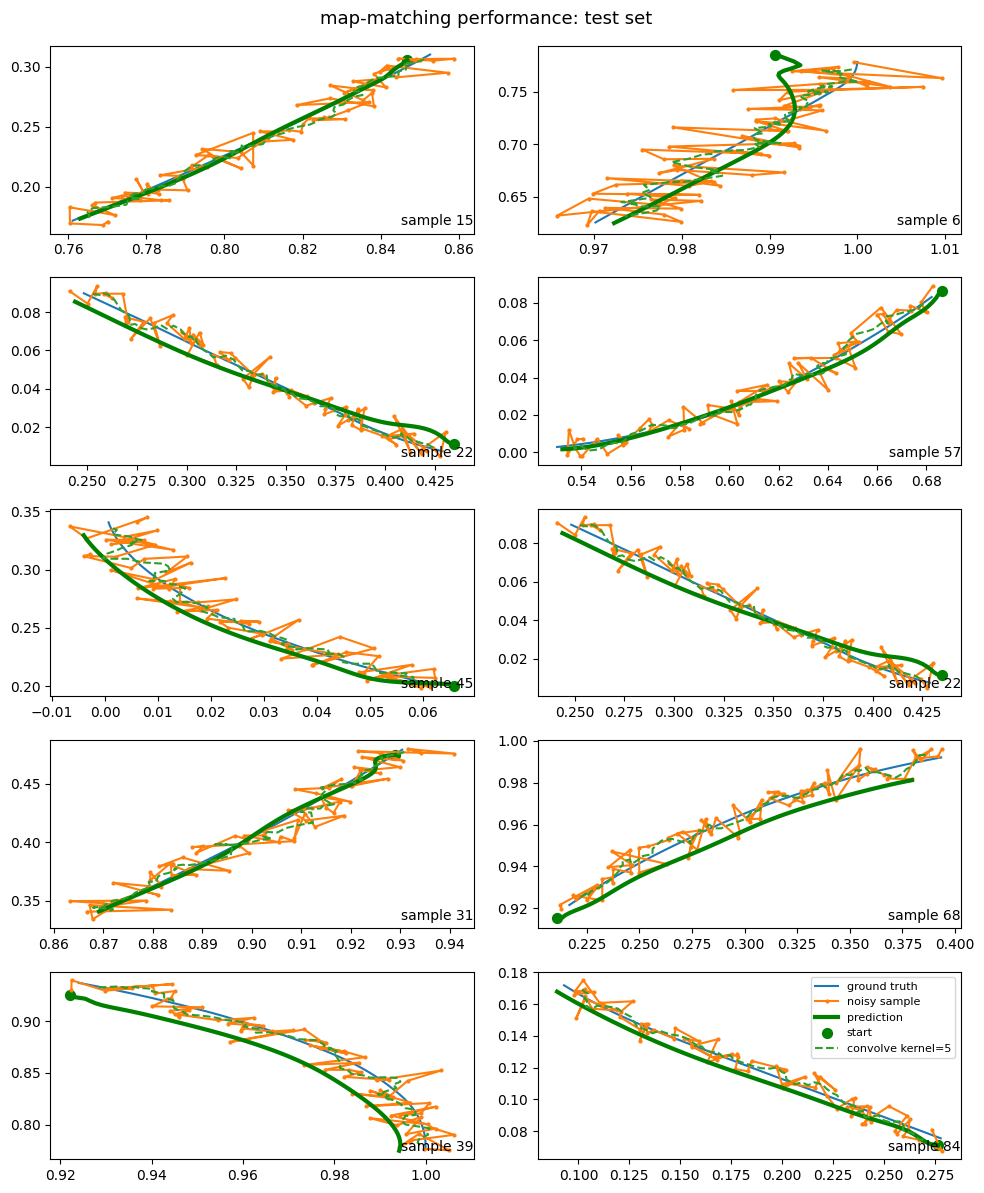

In [127]:
# autoencoder_v3 

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("map-matching performance: test set", fontsize=13, y=0.99)

np.random.seed(17)
for sample, ax in zip(np.random.randint(0, 100, 10), axs.ravel()):
    y_pred = y_test_pred[sample]
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    lat_noisy_convolved = np.convolve(x_test[sample][:, 0], kernel, mode='valid')
    lon_noisy_convolved = np.convolve(x_test[sample][:, 1], kernel, mode='valid')

    ax.plot(y_test[sample][:, 0], y_test[sample][:, 1], label='ground truth')
    ax.plot(x_test[sample][:, 0], x_test[sample][:, 1], '-o', label='noisy sample', ms=2)
    ax.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3, c='green')
    ax.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
    ax.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5')

    ax.set_title(f'sample {sample}', y=0, loc='right', fontdict={'fontsize': 10})

plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

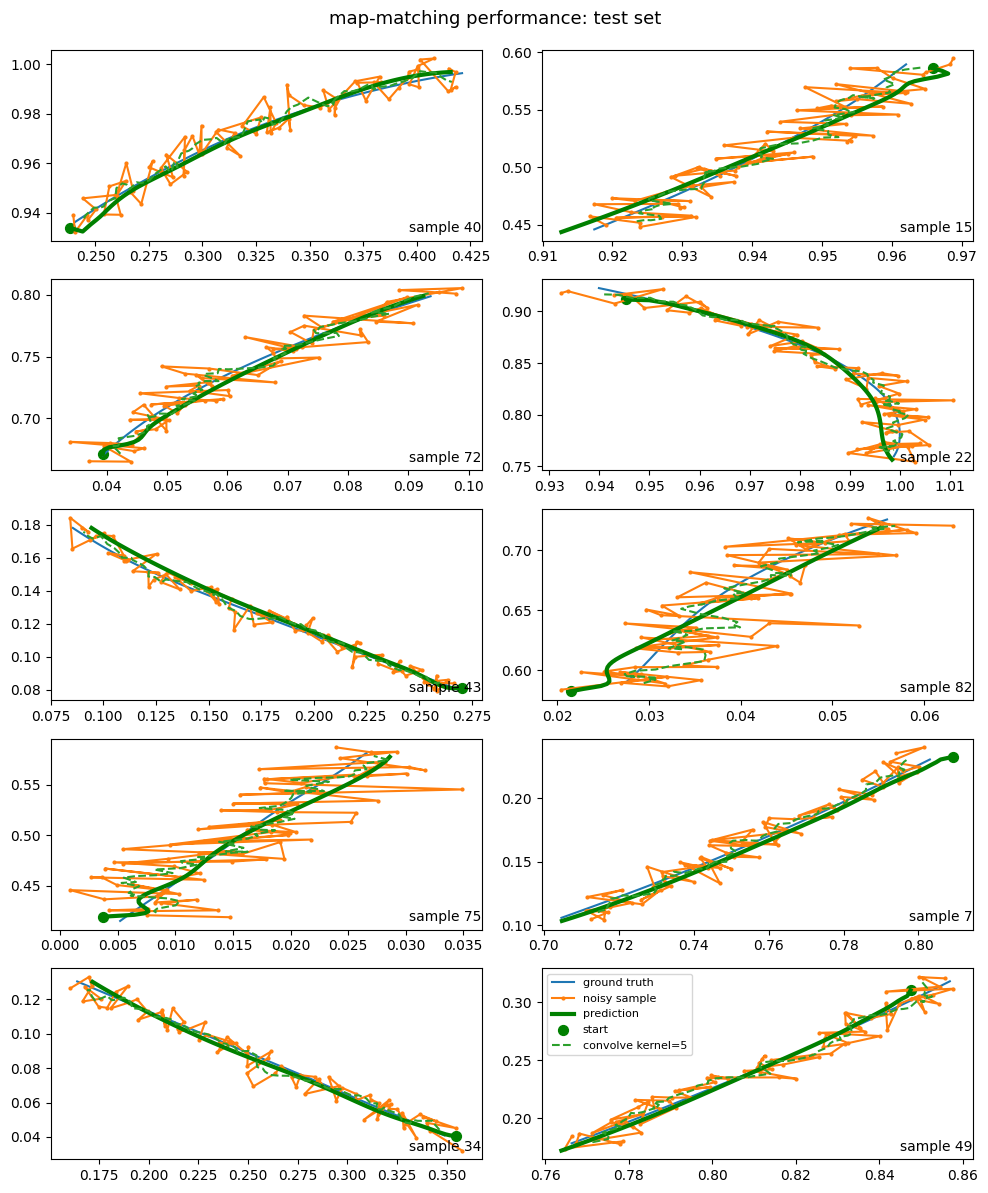

In [93]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("map-matching performance: test set", fontsize=13, y=0.99)

np.random.seed(2)
for sample, ax in zip(np.random.randint(0, 100, 10), axs.ravel()):
    y_pred = y_test_pred[sample]
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    lat_noisy_convolved = np.convolve(x_test[sample][:, 0], kernel, mode='valid')
    lon_noisy_convolved = np.convolve(x_test[sample][:, 1], kernel, mode='valid')

    ax.plot(y_test[sample][:, 0], y_test[sample][:, 1], label='ground truth')
    ax.plot(x_test[sample][:, 0], x_test[sample][:, 1], '-o', label='noisy sample', ms=2)
    ax.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3, c='green')
    ax.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
    ax.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5')

    ax.set_title(f'sample {sample}', y=0, loc='right', fontdict={'fontsize': 10})

plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

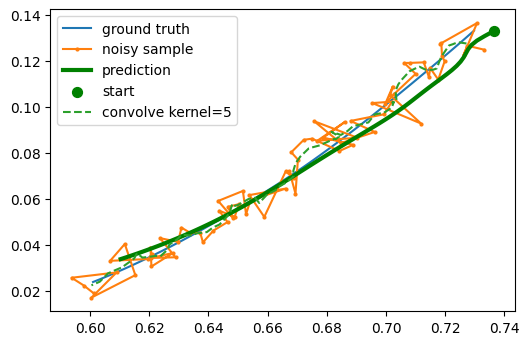

In [89]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
lat_noisy_convolved = np.convolve(x_train[sample][:, 0], kernel, mode='valid')
lon_noisy_convolved = np.convolve(x_train[sample][:, 1], kernel, mode='valid')

plt.plot(y_train[sample][:, 0], y_train[sample][:, 1], label='ground truth')
plt.plot(x_train[sample][:, 0], x_train[sample][:, 1], '-o', label='noisy sample', ms=2)
plt.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3, c='green')
plt.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
plt.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5')

plt.legend()
plt.show()

### feature importance

--------------- > Fold 1 < ---------------
predicting test data...


  0%|          | 0/5 [00:00<?, ?it/s]

computing LSTM feature importance...


100%|██████████| 5/5 [00:00<00:00, 10.79it/s]


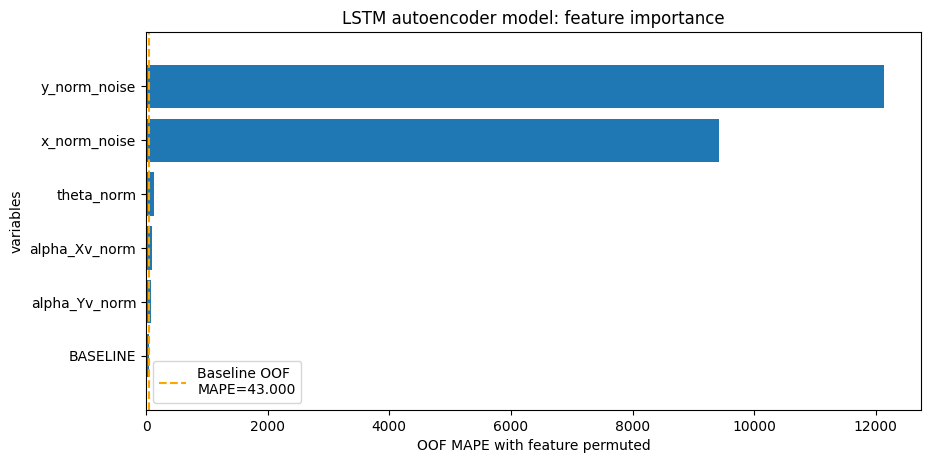

In [160]:
INFER_TEST = True
COMPUTE_LSTM_IMPORTANCE = True
ONE_FOLD_ONLY = True
EPOCH = 300
BATCH_SIZE = 77
NUM_FOLDS = 10
COLS = ['y_norm_noise', 'x_norm_noise', 'theta_norm', 'alpha_Xv_norm', 'alpha_Yv_norm']

# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(x_train, y_train)):
        keras.backend.clear_session()
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = x_train[train_idx], x_train[test_idx]
        y_train, y_valid = y_train[train_idx], y_train[test_idx]
        
        checkpoint_filepath = f"folds{fold}.hdf5"

        if INFER_TEST:
            print('predicting test data...')
            test_preds.append(model_e2d2.predict(x_train, verbose=0).squeeze().reshape(-1, 1).squeeze())
                    
        if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print('computing LSTM feature importance...')
            
            # COMPUTE BASELINE (NO SHUFFLE)
            oof_preds = model_e2d2.predict(X_valid, verbose=0).squeeze() 
            baseline_mape = np.mean(np.abs((oof_preds-y_valid)/y_valid)*100)
            results.append({'feature':'BASELINE','mape':baseline_mape})           

            for k in tqdm(range(len(COLS))):
                
                # SHUFFLE FEATURE K
                save_col = X_valid[:,:,k].copy()
                np.random.shuffle(X_valid[:,:,k])
                        
                # COMPUTE OOF MAPE WITH FEATURE K SHUFFLED
                oof_preds = model_e2d2.predict(X_valid, verbose=0).squeeze() 
                mape = np.mean(np.abs((oof_preds-y_valid)/y_valid)*100)
                results.append({'feature':COLS[k], 'mape':mape})
                X_valid[:,:,k] = save_col
         
            # DISPLAY LSTM FEATURE IMPORTANCE
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mape')
            plt.figure(figsize=(10, 5))
            plt.barh(np.arange(len(COLS)+1),df.mape)
            plt.yticks(np.arange(len(COLS)+1), df.feature.values)
            plt.title('LSTM autoencoder model: feature importance')
            plt.ylim((-1,len(COLS)+1))
            plt.plot([baseline_mape,baseline_mape],[-1,len(COLS)+1], '--', color='orange',
                     label=f'Baseline OOF\nMAPE={baseline_mape:.3f}')
            plt.xlabel(f'OOF MAPE with feature permuted')
            plt.ylabel('variables')
            plt.legend()
            plt.show()
                               
        # ONLY DO ONE FOLD
        if ONE_FOLD_ONLY: break

### accuracy
- evaulate the map-matching results with average 

In [226]:
rl = pd.read_csv('../data/acm_track/rl_clean.csv.gzip', compression='gzip')
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(np.array(rl['x']).reshape(1, -1))
y_scaler.fit(np.array(rl['y']).reshape(1, -1))

MinMaxScaler()

In [262]:
np.array(rl['x']).reshape(1, -1).shape

(1, 70817)

In [230]:
y_pred.shape

(77, 2)

In [229]:
y_pred[0]

array([0.7892267, 0.208286 ], dtype=float32)

In [233]:
y_test_pred[0][:, 0]

array([0.72876924, 0.727979  , 0.7275998 , 0.725779  , 0.72358894,
       0.7214672 , 0.71949524, 0.717634  , 0.71583384, 0.7140682 ,
       0.71233255, 0.71063584, 0.7089891 , 0.7074    , 0.7058699 ,
       0.7043933 , 0.7029603 , 0.7015566 , 0.7001682 , 0.6987804 ,
       0.69738096, 0.6959597 , 0.69450957, 0.69302636, 0.69150764,
       0.6899542 , 0.68836755, 0.6867506 , 0.68510735, 0.6834418 ,
       0.6817586 , 0.68006164, 0.6783548 , 0.6766415 , 0.6749251 ,
       0.6732078 , 0.67149156, 0.66977805, 0.6680681 , 0.66636187,
       0.66465956, 0.66296047, 0.6612632 , 0.6595666 , 0.65786856,
       0.65616643, 0.6544578 , 0.6527391 , 0.65100735, 0.6492589 ,
       0.64748985, 0.6456966 , 0.643876  , 0.642025  , 0.64014107,
       0.6382225 , 0.63626844, 0.63427895, 0.6322554 , 0.6301996 ,
       0.6281155 , 0.6260074 , 0.62388045, 0.6217409 , 0.6195956 ,
       0.6174521 , 0.6153175 , 0.61319965, 0.61110574, 0.6090434 ,
       0.60701907, 0.6050388 , 0.60310864, 0.6012333 , 0.59941

In [248]:
np.array([1, 2]).reshape(2, 1).shape

(2, 1)

In [249]:
np.append(np.array([1, 2]).reshape(2, 1), np.array([1, 2]).reshape(2, 1), 1)

array([[1, 1],
       [2, 2]])

In [261]:
y_test_pred[0][:, 0].reshape(1, -1).shape

(1, 77)

In [259]:
y_scaler.inverse_transform(y_test_pred[0][:, 0].reshape(1, -1))

ValueError: operands could not be broadcast together with shapes (1,77) (70817,) (1,77) 

In [276]:
x_max = -83.55144472
y_max = 42.24829894
x_min = -83.56611364
y_min = 42.23836889

y_test_scale = []
y_pred_scale = []

for i in np.arange(y_test_pred.shape[0]):
    y_scale = y_test_pred[i][:, 0] * (y_max - y_min) + y_min
    x_scale = y_test_pred[i][:, 1] * (x_max - x_min) + x_min
    coord_scale = np.append(
        y_scale.reshape(77, 1), x_scale.reshape(77, 1), axis=1
    )
    y_pred_scale.append(coord_scale)

for i in np.arange(y_test.shape[0]):
    y_scale = y_test[i][:, 0] * (y_max - y_min) + y_min
    x_scale = y_test[i][:, 1] * (x_max - x_min) + x_min
    coord_scale = np.append(
        y_scale.reshape(77, 1), x_scale.reshape(77, 1), axis=1
    )
    y_test_scale.append(coord_scale)

y_test_scale = np.asarray(y_test_scale)
y_pred_scale = np.asarray(y_pred_scale)

In [280]:
great_circie_err = []
for i in np.arange(y_test_pred.shape[0]):
    for traj_i in np.arange(77):
        pred_coord = (y_pred_scale[i][traj_i][0], y_pred_scale[i][traj_i][1])
        actual_coord = (y_test_scale[i][traj_i][0], y_test_scale[i][traj_i][1])
        great_circie_err.append(great_circle(pred_coord, actual_coord).miles * 1609.34) # meter

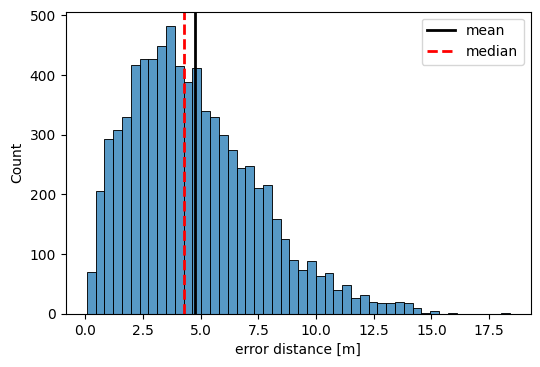

In [286]:
ax = sns.histplot(great_circie_err)
ax.axvline(np.average(great_circie_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('error distance [m]')
plt.legend()